In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import json

from data_utils import MLDataset, collate_fn
from modeling_challenge import Seq2SeqModel

In [5]:
assert torch.cuda.is_available()

# Use 0th GPU for training
torch.cuda.set_device(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# fix random seed to increase reproducibility
# NOTE: Do not modify here!
NUM_CLASSES = 26 + 2  # 26 alphabets + 1 padding index + 1 <s> token (start token)

random_seed = 7
torch.manual_seed(random_seed)
os.environ["PYTHONHASHSEED"] = str(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# %env CUBLAS_WORKSPACE_CONFIG=:16:8


def seed_worker(worker_seed):
    np.random.seed(worker_seed)
    random.seed(worker_seed)


num_workers = 8

In [6]:
# Select augmentations to apply
augmentations = [
    "random_translate",
    "color_jitter",
    "random_rotation",
    "gaussian_blur",
    "random_swap,"
]

In [7]:
# NOTE: modify path and batch size for your setting
# NOTE: you can apply custom preprocessing to the training data

BATCH_SIZE = 128

train_ds = MLDataset("data_final/imgs/train", "data_final/labels/train.json", augmentations=augmentations)
valid_ds = MLDataset(
    "data_final/imgs/valid_normal", "data_final/labels/valid_normal.json"
)
challenge_ds = MLDataset(
    "data_final/imgs/valid_challenge", "data_final/labels/valid_challenge.json"
)

train_dl = DataLoader(
    train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True
)
valid_dl = DataLoader(
    valid_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False
)
challenge_dl = DataLoader(
    challenge_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False
)

In [8]:
# You can add or modify your Seq2SeqModel's hyperparameter (keys and values)
kwargs = {
    'hidden_dim': 256,       # Hidden dimension size for RNN
    'nhead': 4,              # Number of attention heads in the Transformer
    'dec_layers': 4,         # Number of layers in the Transformer decoder
    'dim_feedforward': 1024, # Dimension of feedforward layers in the Transformer
    'dropout': 0.2,          # Dropout rate for the Transformer
    'enc_layers': 3,         # Number of RNN layers in the encoder
    'rnn_dropout': 0.2,      # Dropout rate for the RNN in the encoder
    'max_length': 11,        # Maximum length of the sequences
    'cnn_settings': {        # Settings for the CustomCNN
        'block1_dim': 32,
        'block2_dim': 64,
        'block3_dim': 128,
        'fc_dim': 256,
        'model_type': 'VGG'  # Type of CNN ('VGG' or 'ResNet')
    },
}

In [9]:
model = Seq2SeqModel(num_classes=NUM_CLASSES, **kwargs).to(device)
print(model)
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
model_optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(model_optim, step_size=10, gamma=0.5)
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

Seq2SeqModel(
  (encoder): Encoder(
    (cnn): CustomCNN(
      (block1): VGGBlock(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (block2): VGGBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (block3): VGGBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (fc): Linear(in_features=1152, out_features=256, bias=True)
 

In [10]:
# Print number of parameters for the model
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 8096572


In [11]:
# NOTE: you can freely modify or add training hyperparameters
print_interval = 1000
max_epoch = 20
patience = 2
vis = True

In [12]:
# Define the training function
def train(
        model,
        model_optim,
        loss_fn,
        max_epoch,
        train_dl,
        valid_dl,
        load_path=None,
        save_path='./model.pt',
        patience=5,
        initial_teacher_forcing_ratio=1.0,
        teacher_forcing_decay=0.95,
        scheduler=None,
        device='cuda'
    ):
    # Load the model state if a checkpoint is provided
    loaded_epoch = 0
    loaded_best_valid_loss = -1
    if load_path is not None:
        state = torch.load(load_path)
        model.load_state_dict(state["model"])
        model_optim.load_state_dict(state["optimizer"])
        loaded_epoch = state["epoch"]
        loaded_best_valid_loss = state["best_valid_loss"]
        
    best_valid_loss = 1e+10 if loaded_best_valid_loss == -1 else loaded_best_valid_loss
    no_improvement_epochs = 0

    train_losses = []
    valid_losses = []
    accuracies = []

    teacher_forcing_ratio = initial_teacher_forcing_ratio

    for epoch in np.array(list(range(max_epoch - loaded_epoch))) + loaded_epoch:
        model.train()
        train_loss = 0
        for _, (data, target, lengths) in enumerate(tqdm(train_dl)):
            data = data.to(device)
            target = target.to(device)
            start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)

            # Teacher forcing
            decoder_input = torch.cat([start_tokens, target[:, :-1]], dim=1)
            
            model_optim.zero_grad()
                        
            output = model(data, lengths, decoder_input, teacher_forcing_ratio)

            # Ensure the shapes are correctly matched
            output = output.contiguous().view(-1, NUM_CLASSES)  # (batch_size * seq_len, num_classes)
            target = target.contiguous().view(-1)  # (batch_size * seq_len)
            
            loss = loss_fn(output, target)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            model_optim.step()
            train_loss += loss.detach().cpu().item()

        train_loss_avg = train_loss / len(train_dl)
        train_losses.append(train_loss_avg)
        
        if scheduler is not None:
            scheduler.step()
        
        valid_loss = 0
        correct_sequences = 0
        total_sequences = 0

        model.eval()
        for _, (data, target, lengths) in enumerate(tqdm(valid_dl)):            
            with torch.no_grad():
                data = data.to(device)
                target = target.to(device)
                start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
                
                decoder_input = torch.cat([start_tokens, target[:, :-1]], dim=1)
                output = model(data, lengths, decoder_input, teacher_forcing_ratio=0.0)  # No teacher forcing during validation
                
                # Ensure the shapes are correctly matched
                output = output.contiguous().view(-1, output.size(-1))  # (batch_size * seq_len, num_classes)
                target = target.contiguous().view(-1)  # (batch_size * seq_len)
                
                loss = loss_fn(output, target)
                valid_loss += loss.cpu().item()

                logits = output.view(data.size(0), -1, output.size(-1))
                predicted_sequences = torch.argmax(logits, dim=-1)
                for i in range(data.size(0)):
                    pred_seq = predicted_sequences[i][:int(lengths[i])]
                    target_seq = target.view(data.size(0), -1)[i][:int(lengths[i])]
                    if torch.equal(pred_seq, target_seq):
                        correct_sequences += 1
                    total_sequences += 1
        
        valid_loss /= len(valid_dl)
        accuracy = correct_sequences / total_sequences
        accuracies.append(accuracy)
        valid_losses.append(valid_loss)

        if valid_loss < best_valid_loss:
            print("New best valid loss, saving model")
            state = {
                "model": model.state_dict(),
                "optimizer": model_optim.state_dict(),
                "epoch": epoch + 1,
                "best_valid_loss": valid_loss,
            }
            torch.save(state, save_path)
            best_valid_loss = valid_loss
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        print(f'epoch {epoch + 1}, train loss: {train_loss_avg:.4f}, valid loss: {valid_loss:.4f}, best valid loss: {best_valid_loss:.4f}, accuracy: {accuracy:.4f}')

        teacher_forcing_ratio *= teacher_forcing_decay

        if no_improvement_epochs >= patience:
            print(f"No improvement in validation loss for {patience} epochs. Stopping training.")
            break

    return train_losses, valid_losses, accuracies

In [13]:
train_losses, valid_losses, accuracies = train(
    model,
    model_optim,
    loss_fn,
    max_epoch=20,
    train_dl=train_dl,
    valid_dl=valid_dl,
    load_path=None,
    save_path='./model.pt',
    patience=2,
    initial_teacher_forcing_ratio=1.0,
    teacher_forcing_decay=0.95,
    scheduler=scheduler,
    device=device
)

100%|██████████| 76/76 [00:06<00:00, 11.54it/s]


New best valid loss, saving model
epoch 1, train loss: 1.4453, valid loss: 1.3183, best valid loss: 1.3183, accuracy: 0.3684


100%|██████████| 76/76 [00:07<00:00, 10.66it/s]


New best valid loss, saving model
epoch 2, train loss: 0.3997, valid loss: 0.9506, best valid loss: 0.9506, accuracy: 0.5584


100%|██████████| 76/76 [00:07<00:00, 10.71it/s]


New best valid loss, saving model
epoch 3, train loss: 0.2745, valid loss: 0.6859, best valid loss: 0.6859, accuracy: 0.6999


100%|██████████| 76/76 [00:07<00:00, 10.57it/s]


New best valid loss, saving model
epoch 4, train loss: 0.2244, valid loss: 0.5258, best valid loss: 0.5258, accuracy: 0.7490


100%|██████████| 76/76 [00:07<00:00, 10.69it/s]


New best valid loss, saving model
epoch 5, train loss: 0.2028, valid loss: 0.3961, best valid loss: 0.3961, accuracy: 0.7939


100%|██████████| 76/76 [00:06<00:00, 11.45it/s]


New best valid loss, saving model
epoch 6, train loss: 0.1860, valid loss: 0.3757, best valid loss: 0.3757, accuracy: 0.8099


100%|██████████| 76/76 [00:07<00:00, 10.66it/s]


New best valid loss, saving model
epoch 7, train loss: 0.1795, valid loss: 0.3351, best valid loss: 0.3351, accuracy: 0.8438


100%|██████████| 76/76 [00:06<00:00, 11.43it/s]


New best valid loss, saving model
epoch 8, train loss: 0.1796, valid loss: 0.2820, best valid loss: 0.2820, accuracy: 0.8421


100%|██████████| 76/76 [00:06<00:00, 11.41it/s]


epoch 9, train loss: 0.1773, valid loss: 0.3046, best valid loss: 0.2820, accuracy: 0.8448


100%|██████████| 76/76 [00:07<00:00, 10.72it/s]


New best valid loss, saving model
epoch 10, train loss: 0.1785, valid loss: 0.2603, best valid loss: 0.2603, accuracy: 0.8624


100%|██████████| 76/76 [00:06<00:00, 11.48it/s]


New best valid loss, saving model
epoch 11, train loss: 0.1060, valid loss: 0.1970, best valid loss: 0.1970, accuracy: 0.9041


100%|██████████| 76/76 [00:06<00:00, 11.45it/s]


New best valid loss, saving model
epoch 12, train loss: 0.0904, valid loss: 0.1729, best valid loss: 0.1729, accuracy: 0.9113


100%|██████████| 76/76 [00:06<00:00, 11.55it/s]


epoch 13, train loss: 0.0847, valid loss: 0.2062, best valid loss: 0.1729, accuracy: 0.9016


100%|██████████| 76/76 [00:07<00:00, 10.75it/s]

epoch 14, train loss: 0.0828, valid loss: 0.1870, best valid loss: 0.1729, accuracy: 0.9082
No improvement in validation loss for 2 epochs. Stopping training.


In [14]:
import matplotlib.pyplot as plt

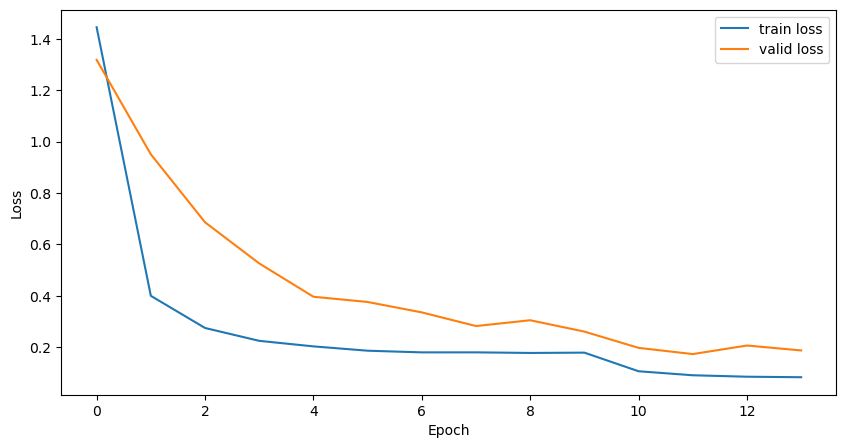

In [15]:
# Plot the training and validation losses over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

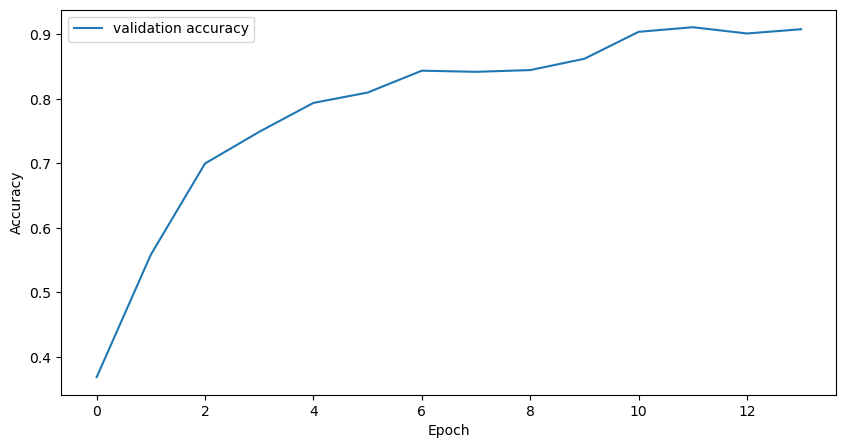

In [16]:
# Plot the validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model evaluation


In [17]:
kwargs_generate = {
    "max_length": 10,
}

In [18]:
# Do not modify this cell!


def eval(dataloader, model_path):
    state = torch.load(model_path)
    model.load_state_dict(state["model"])
    model.eval()

    id_to_char = {}
    id_to_char[0] = "<pad>"
    id_to_char[27] = "<s>"
    alphabets = "abcdefghijklmnopqrstuvwxyz"
    for i, c in enumerate(alphabets):
        id_to_char[i + 1] = c

    results = []
    labels = []
    for batch_idx, (data, target, lengths) in enumerate(tqdm(dataloader)):
        data = data.to(device)  # (B, T, H, W, C)
        target = target.to(device)  # (B, T)

        # start tokens should be located at the first position of the decoder input
        start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
        with torch.no_grad():
            generated_tok = model.generate(
                data, lengths, start_tokens, **kwargs_generate
            )  # (B, T)

        for i in range(generated_tok.size(0)):
            decoded = ""
            for j in generated_tok[i][: lengths[i].int()].tolist():
                decoded += id_to_char[j]
            results.append(decoded)

            decoded = ""
            for j in target[i][: lengths[i].int()].tolist():
                decoded += id_to_char[j]
            labels.append(decoded)

    corrects = []
    for i in range(len(results)):
        if results[i] == labels[i]:
            corrects.append(1)
        else:
            corrects.append(0)
    print("Accuracy: %.5f" % (sum(corrects) / len(corrects)))

    return results, labels

In [19]:
# load and evaluate your model
load_path = "./model.pt"
print("Evaluation with validation set")
results, labels = eval(valid_dl, load_path)

print("Evaluation with challenge set")
results, labels = eval(challenge_dl, load_path)

Evaluation with validation set


100%|██████████| 76/76 [00:08<00:00,  9.22it/s]


Accuracy: 0.91127
Evaluation with challenge set


100%|██████████| 69/69 [00:08<00:00,  8.48it/s]

Accuracy: 0.77714
